# Subsetting STOFS-3D files and creating an hgrid file for that

This is for supporting NOAA/NCCOS/Cooperative Oxford Lab.

**To run the code please follow the steps below:**



## 1- Create a Python Virtual Environment on Your Machine

- If you haven't already installed Miniconda, please use the following commands to download and install it:

```
wget -nH -m -nd https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
bash Miniconda3-latest-Linux-x86_64.sh
```

## 2- Install the Required Libraries in the Python Environment

- Run the following commands to install the necessary libraries and packages:

```
wget https://github.com/AtiehAlipour-NOAA/Subsetting/blob/main/environment.yml

conda create -n subsetting2 -f environment.yml

conda activate subsetting2

```


## 3- Run the Following Cell to Import the Required Libraries


In [1]:
# Import required libraries
import os
# This must be set before we start writing files on a Lustre filesystem
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import xarray as xr
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import fsspec
fs = fsspec.filesystem("s3", anon=True)
import numpy.typing as npt
import thalassa  
from thalassa import api  
from thalassa import normalization
from thalassa import utils


In [2]:
import numpy.typing as npt
import thalassa.utils

# This manually assigns 'npt' to the utility module where it's missing
thalassa.utils.npt = npt

## 4- Define the Input and Run the Code
This code is designed to subset STOFS-3D-Atlantic forecast data for specific variables, date, and geographic areas that you specify.
You will need to provide a bounding box that defines the area of interest for subsetting the data.

Below is an example of subsetting area for the Oxford Town, MD.

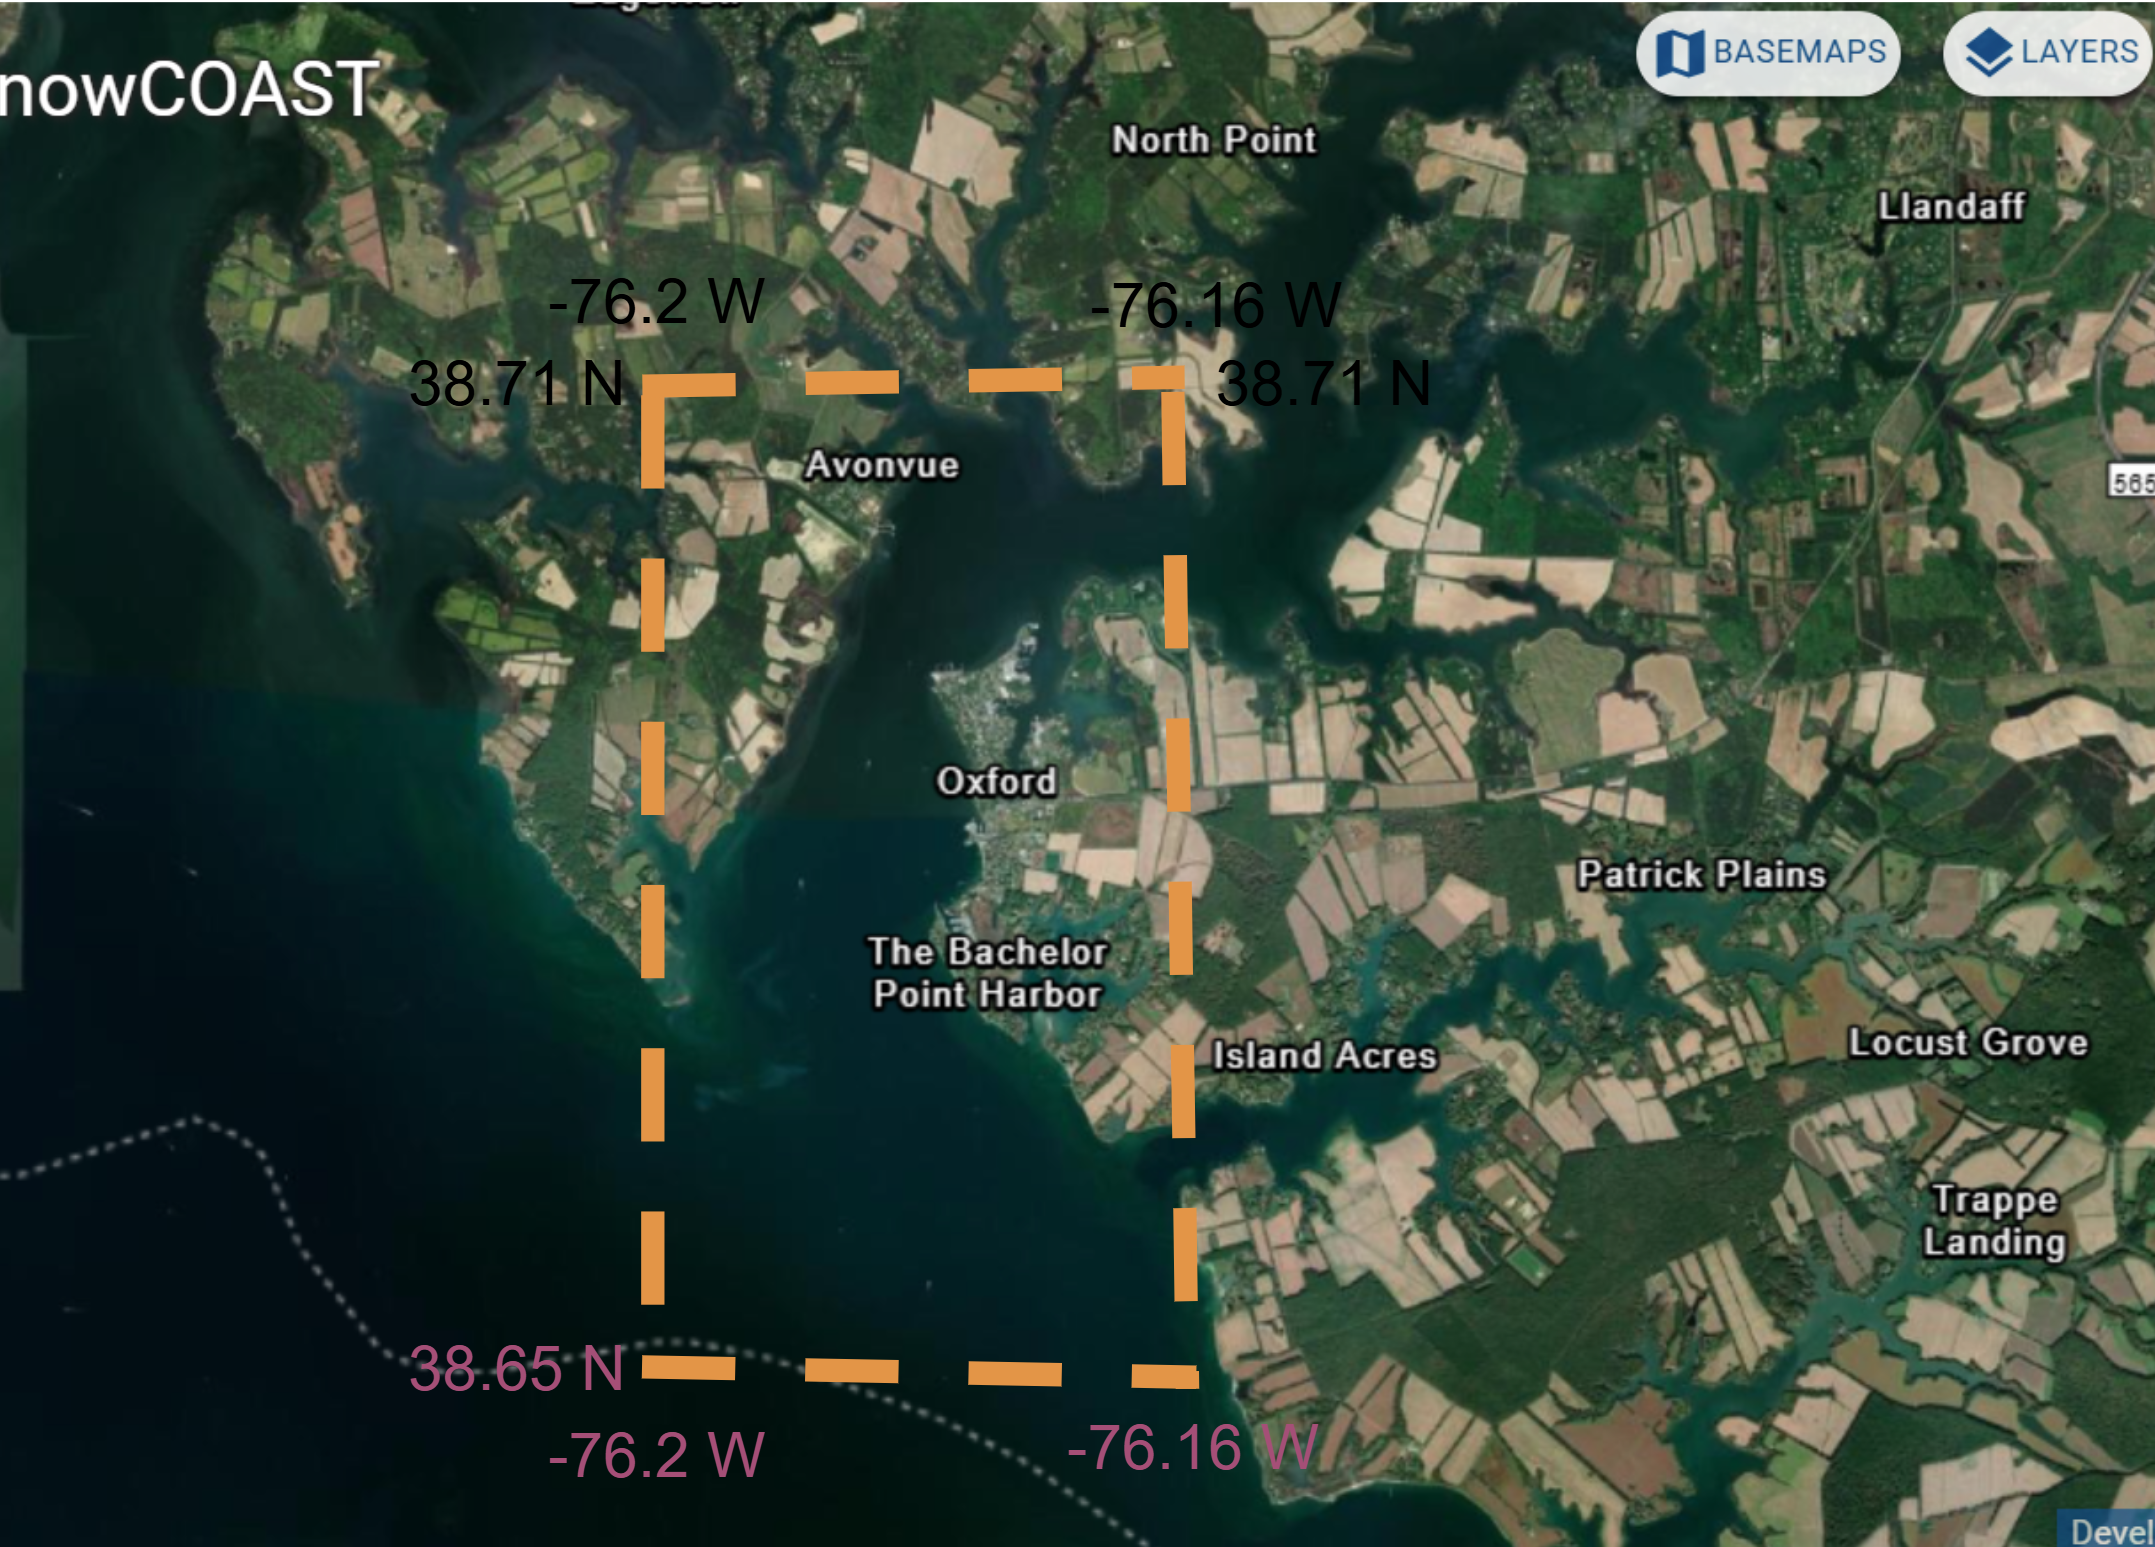

In [5]:
# Define the inputs

date = '20251208' # date to subset
variables = ['out2d','horizontalVelX','horizontalVelY','salinity','temperature','zCoordinates']  # list of files for subsetting
F_hours =  48 # Number of forecast hours must be a multiple of 12, up to 96 (currently, each STOFS file contains 12 hours of forecast data)
box = (-76.2, -76.16, 36.65, 38.71) # (min lon, min lon, min lat, max lat)
boundary_shp_path = '/lustre/code/Subsetting/Subsetting/notebooks/HAB_Sample/potomac_open_boundary.shp'# path to boundary shp
name = 'OxfordTown' # name of the area of interest
atl_bucket_name = 'noaa-nos-stofs3d-pds' # STOFS 3d bucket name
atl_S3_dir = 'STOFS-3D-Atl' # STOFS 3d directory
output_path = '/lustre/code/Subsetting/Subsetting/notebooks/Oxford_Town/subset_data' # Replace this with the path of the directory you want to save subset data


In [6]:
# This step is done once to read mesh topology information from the out2d file, which is needed for subsetting other STOFS files.
ds_out2d = xr.open_dataset(
    fs.open(
        f"s3://{atl_bucket_name}/{atl_S3_dir}/stofs_3d_atl.{date}/stofs_3d_atl.t12z.fields.out2d_f001_012.nc"
    ),
    chunks={},
    engine='h5netcdf'
)

ref_ds_out2d = ds_out2d.rename({'nSCHISM_hgrid_node': 'node', 'nSCHISM_hgrid_face': 'nele', 'nMaxSCHISM_hgrid_face_nodes': 'nvertex', 'SCHISM_hgrid_face_nodes':'element', 'nSCHISM_hgrid_edge':'edge'})
ref_ds_out2d = ref_ds_out2d.rename({'SCHISM_hgrid_node_x': 'x', 'SCHISM_hgrid_node_y': 'y'})

# List of variable names to add
vars_to_add = ['element','x','y']
selected_vars = ref_ds_out2d[vars_to_add]

ref_ds_out2d


<xarray.Dataset> Size: 3GB
Dimensions:                  (time: 12, node: 2926236, one: 1, nele: 5654157,
                              nvertex: 4, edge: 8580540, two: 2)
Coordinates:
  * time                     (time) datetime64[ns] 96B 2025-12-08T13:00:00 .....
    x                        (node) float64 23MB dask.array<chunksize=(2926236,), meta=np.ndarray>
    y                        (node) float64 23MB dask.array<chunksize=(2926236,), meta=np.ndarray>
    SCHISM_hgrid_face_x      (nele) float64 45MB dask.array<chunksize=(5654157,), meta=np.ndarray>
    SCHISM_hgrid_face_y      (nele) float64 45MB dask.array<chunksize=(5654157,), meta=np.ndarray>
    SCHISM_hgrid_edge_x      (edge) float64 69MB dask.array<chunksize=(8580540,), meta=np.ndarray>
    SCHISM_hgrid_edge_y      (edge) float64 69MB dask.array<chunksize=(8580540,), meta=np.ndarray>
Dimensions without coordinates: node, one, nele, nvertex, edge, two
Data variables: (12/20)
    elevation                (time, node) float32 140MB dask.array<chunksize=(1, 975412), meta=np.ndarray>
    minimum_depth            (one) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    SCHISM_hgrid             (one) |S1 1B dask.array<chunksize=(1,), meta=np.ndarray>
    crs                      (one) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    depth                    (node) float32 12MB dask.array<chunksize=(2926236,), meta=np.ndarray>
    bottom_index_node        (node) int32 12MB dask.array<chunksize=(2926236,), meta=np.ndarray>
    ...                       ...
    windStressY              (time, node) float32 140MB dask.array<chunksize=(1, 975412), meta=np.ndarray>
    depthAverageVelX         (time, node) float32 140MB dask.array<chunksize=(1, 975412), meta=np.ndarray>
    depthAverageVelY         (time, node) float32 140MB dask.array<chunksize=(1, 975412), meta=np.ndarray>
    dryFlagElement           (time, nele) float32 271MB dask.array<chunksize=(1, 942360), meta=np.ndarray>
    dryFlagSide              (time, edge) float32 412MB dask.array<chunksize=(1, 953394), meta=np.ndarray>
    idmask                   (node) int32 12MB dask.array<chunksize=(2926236,), meta=np.ndarray>
Attributes:
    NCO:                        netCDF Operators version 4.9.7 (Homepage = ht...
    history_of_appended_files:  Mon Dec  8 18:05:53 2025: Appended file /lfs/...
    history:                    Mon Dec  8 18:06:54 2025: ncatted -O -a missi...

In [7]:
# subsetting function usinsg Thalassa package

def subset_thalassa(ds, box):
    """
    Function to subset a thalassa Dataset based on a polygon using shapely.
    
    Parameters:
    - ds: thalassa Dataset containing the data
    - polygon: shapely polygon
    
    Returns:
    - new_ds: Subset of the input dataset within the specified polygon
    """
    new_ds = thalassa.crop(ds, box)  # Crop the dataset using the bounding box
    return new_ds


In [9]:


# subsetting specified STOFS data and saving the .nc files 
for variable in variables:

    # Create the output directory if it does not exist
    os.makedirs(output_path, exist_ok=True)
    
    for hours in range(0, F_hours, 12):
        hr_start = hours + 1
        hr_end = hours + 12
        
        # Path for the input file (S3) and output file (Local Lustre)
        s3_path = f"s3://{atl_bucket_name}/{atl_S3_dir}/stofs_3d_atl.{date}/stofs_3d_atl.t12z.fields.{variable}_f0{hr_start:02d}_0{hr_end:02d}.nc"
        output_file = f"{output_path}/{variable}_{date}_0{hr_start:02d}_0{hr_end:02d}.nc"

        if variable == 'out2d':
            # Open the dataset from NODD s3 bucket directly
            ds = xr.open_dataset(
                fs.open(s3_path),
                chunks={},
                engine='h5netcdf',
                drop_variables=['nvel']
            )
            
            # Rename to thalassa-friendly names
            ds = ds.rename({
                'nSCHISM_hgrid_node': 'node', 
                'nSCHISM_hgrid_face': 'nele', 
                'nMaxSCHISM_hgrid_face_nodes': 'nvertex', 
                'SCHISM_hgrid_face_nodes':'element', 
                'nSCHISM_hgrid_edge':'edge',
                'SCHISM_hgrid_node_x': 'x', 
                'SCHISM_hgrid_node_y': 'y'
            })
            
            ds = thalassa.normalize(ds) 
            ds_subset = subset_thalassa(ds, box)  # Subset the Thalassa dataset

        else:
            # Open the dataset from NODD s3 bucket directly
            ds = xr.open_dataset(
                fs.open(s3_path),
                chunks={},
                engine='h5netcdf',
                drop_variables=['nvel']
            )
            
            ds = ds.rename({'nSCHISM_hgrid_node': 'node'})            
            ds = ds.merge(selected_vars)
            ds = thalassa.normalize(ds) 
            ds_subset = subset_thalassa(ds, box) 

        # --- CLEANING AND CONVERTING BACK TO SCHISM FORMAT ---
        unwanted_dims = {"face", "edge"}
        vars_to_drop = [v for v in ds_subset.data_vars if any(dim in unwanted_dims for dim in ds_subset[v].dims)]
        coords_to_drop = [c for c in ds_subset.coords if any(dim in unwanted_dims for dim in ds_subset[c].dims)]

        ds_cleaned = ds_subset.drop_vars(vars_to_drop + coords_to_drop)
        
        ds_schism = ds_cleaned.rename({
            'node': 'nSCHISM_hgrid_node',
            'triface': 'nSCHISM_hgrid_face',
            'three': 'nMaxSCHISM_hgrid_face_nodes',
            'triface_nodes': 'SCHISM_hgrid_face_nodes',
            'lon': 'SCHISM_hgrid_node_x',
            'lat': 'SCHISM_hgrid_node_y',
        })

        
        # Clear encoding for all variables to prevent metadata conflicts with the subsetted shape
        for var in ds_schism.variables:
            ds_schism[var].encoding = {}

       
        # Use engine="h5netcdf" as it handles cluster environments better than netcdf4
        ds_schism.to_netcdf(output_file, engine="h5netcdf")
            
        print(f"{variable}_{date}_{hr_start:02d}_{hr_end:02d}.nc is saved!")

out2d_20251208_01_12.nc is saved!
out2d_20251208_13_24.nc is saved!
out2d_20251208_25_36.nc is saved!
out2d_20251208_37_48.nc is saved!
horizontalVelX_20251208_01_12.nc is saved!
horizontalVelX_20251208_13_24.nc is saved!
horizontalVelX_20251208_25_36.nc is saved!
horizontalVelX_20251208_37_48.nc is saved!
horizontalVelY_20251208_01_12.nc is saved!
horizontalVelY_20251208_13_24.nc is saved!
horizontalVelY_20251208_25_36.nc is saved!
horizontalVelY_20251208_37_48.nc is saved!
salinity_20251208_01_12.nc is saved!
salinity_20251208_13_24.nc is saved!
salinity_20251208_25_36.nc is saved!
salinity_20251208_37_48.nc is saved!
temperature_20251208_01_12.nc is saved!
temperature_20251208_13_24.nc is saved!
temperature_20251208_25_36.nc is saved!
temperature_20251208_37_48.nc is saved!
zCoordinates_20251208_01_12.nc is saved!
zCoordinates_20251208_13_24.nc is saved!
zCoordinates_20251208_25_36.nc is saved!
zCoordinates_20251208_37_48.nc is saved!
